In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import VerticalPitch
import requests
from datetime import datetime, timedelta
import unicodedata

In [2]:
def date_query(start_date, end_date):
    #formats date and makes sure everything will be in datetime
    date_format = "%Y-%m-%d"
    start = datetime.strptime(start_date, date_format)
    end = datetime.strptime(end_date, date_format)
    delta = timedelta(days=1)
    #stores all the dataframes from the query
    frames = []
    #goes through each day one by one and grabs the dataframes
    while start <= end:
        date_str = start.strftime(date_format)
        url = f"https://www.sofascore.com/api/v1/sport/football/scheduled-events/{date_str}"
        response = requests.get(url)

        if response.status_code == 200:
            data = response.json()
            events = data.get('events', [])

            if events:
                df = pd.json_normalize(events)
                df['Date'] = date_str

                # Select specific columns
                selected_columns = ['homeTeam.name', 'awayTeam.name', 'id', 'homeScore.current', 'awayScore.current',
                                    'tournament.name', 'season.id', 'tournament.id', 'Date']

                df_selected = df[selected_columns]

                # Rename columns for clarity
                df_selected.columns = ['Home Team', 'Away Team', 'Event ID', 'Home Score', 'Away Score',
                                       'Tournament Name', 'Season ID', 'Tournament ID', 'Date']

                frames.append(df_selected)
        else:
            print(f"Failed to fetch data for {date_str}. Status code: {response.status_code}")

        start += delta

    if frames:
        result_df = pd.concat(frames, ignore_index=True)
        return result_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data was fetched

# Example usage
df_result = date_query('2023-08-23', '2024-05-21')

Filtered Rows:
             Home Team  Away Team  Event ID  Home Score  Away Score  \
31190  Manchester City  Liverpool  11352373         1.0         1.0   
31451  Manchester City  Liverpool  11352373         1.0         1.0   
32031  Manchester City  Liverpool  11352373         1.0         1.0   

      Tournament Name  Season ID  Tournament ID        Date  
31190  Premier League    52186.0              1  2023-11-24  
31451  Premier League    52186.0              1  2023-11-25  
32031  Premier League    52186.0              1  2023-11-26  


/var/folders/8_/_mkv7dtj7hvfvhvj31qsy35h0000gn/T/ipykernel_19208/1537565103.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['edge_color'] = '#ea6969'  # Default edge color
/var/folders/8_/_mkv7dtj7hvfvhvj31qsy35h0000gn/T/ipykernel_19208/1537565103.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['face_color'] = 'none'  # Blank face color
/var/folders/8_/_mkv7dtj7hvfvhvj31qsy35h0000gn/T/ipykernel_19208/1537565103.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

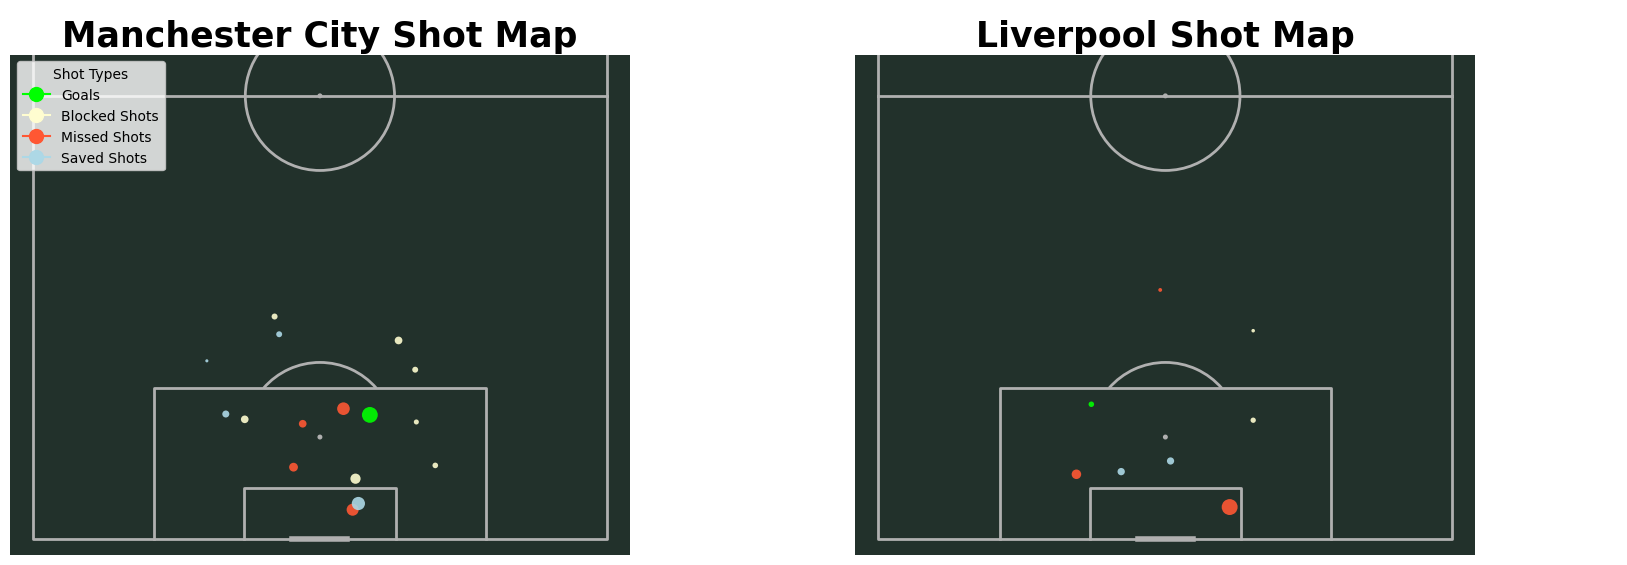

In [39]:
def normalize_team_names(team_name):
    return unicodedata.normalize('NFD', team_name).encode('ascii', 'ignore').decode('utf-8').lower().strip()

def get_match_id(home_team, away_team, tournament_name):
    # Normalize team names
    normalized_home_team = normalize_team_names(home_team)
    normalized_away_team = normalize_team_names(away_team)
    normalized_tournament_name = normalize_team_names(tournament_name)
    

    match_info = df_result[(df_result['Home Team'].apply(normalize_team_names) == normalized_home_team) & 
                    (df_result['Away Team'].apply(normalize_team_names) == normalized_away_team) & 
                    (df_result['Tournament Name'].apply(normalize_team_names) == normalized_tournament_name)]
    
    print("Filtered Rows:")
    print(match_info)
    
    if match_info.empty:
        print("Match not found.")
        return None
    
    # Get the match ID
    match_id = match_info.iloc[0]['Event ID']
    
    return match_id


def plot_shotmap(match_identifier):
    if isinstance(match_identifier, int):
        match_id = match_identifier
    elif isinstance(match_identifier, tuple) and len(match_identifier) == 3:
        home_team, away_team, tournament_name = match_identifier
        match_id = get_match_id(home_team, away_team, tournament_name)
        if match_id is None:
            return
    else:
        print("Invalid match identifier. Must be an integer ID or a tuple of (home_team, away_team, tournament_name).")
        return

    response = requests.get(f'https://sofascore.com/api/v1/event/{match_id}/shotmap')
    shots = response.json()

    # Normalize the shotmap data into a DataFrame
    df = pd.json_normalize(shots['shotmap'])
    
    df = df[df['situation'] != 'shootout']
    
    # Define the selected columns
    selected_columns = ['isHome', 'shotType', 'situation', 'bodyPart', 'goalMouthLocation',
                        'xg', 'id', 'time', 'addedTime', 'timeSeconds', 'reversedPeriodTime',
                        'reversedPeriodTimeSeconds', 'incidentType', 'player.name', 'player.position', 
                        'player.jerseyNumber', 'player.id', 'playerCoordinates.x', 'playerCoordinates.y', 
                        'playerCoordinates.z', 'goalMouthCoordinates.x', 'goalMouthCoordinates.y', 
                        'goalMouthCoordinates.z', 'blockCoordinates.x', 'blockCoordinates.y', 'blockCoordinates.z', 
                        'draw.start.x', 'draw.start.y', 'draw.block.x', 'draw.block.y', 'draw.end.x', 'draw.end.y', 
                        'draw.goal.x', 'draw.goal.y', 'goalType', 'xgot']

    # Filter the DataFrame to include only the selected columns
    result_df = df[selected_columns]
    
    # Shift the 'draw.start.x' column values
    #shift_value = 10  
    #result_df['draw.start.x'] -= shift_value

    # Filter result_df where 'isHome' column is true
    result_df_home = result_df[result_df['isHome']]
    # Filter result_df where 'isHome' column is false
    result_df_away = result_df[~result_df['isHome']]

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 6.5))

    for ax, df, team_name in zip(axes, [result_df_home, result_df_away], [home_team, away_team]):
        # Create a VerticalPitch with half=True need to pad since the coords are for the bottom half.
        pitch = VerticalPitch(pitch_type='opta', half=True, pad_top=-70, pad_bottom=80, pitch_color='#22312b')  # Set background color to #22312b

        # Get the figure and axis objects from the pitch
        pitch.draw(ax=ax)

        df['edge_color'] = '#ea6969'  # Default edge color
        df['face_color'] = 'none'  # Blank face color

        # Change the edge color based on shot type
        df.loc[df['shotType'] == 'goal', 'edge_color'] = '#00FF00'  # Goal
        df.loc[df['shotType'] == 'block', 'edge_color'] = '#fffdd0'  # Block
        df.loc[df['shotType'] == 'miss', 'edge_color'] = '#FF5733'  # Miss
        df.loc[df['shotType'] == 'save', 'edge_color'] = '#ADD8E6'  # Save

        # Draw the scatter plot on the main pitch with solid circles and respective edge colors
        scatter = ax.scatter(df['draw.start.x'], df['draw.start.y'], facecolors=df['edge_color'],
                             edgecolors='none', marker='o', s=df['xg']*500, linewidth=1, alpha=.9, label='Shots Missed')

        # Customize the scatter plot as needed
        ax.set_title(f'{team_name} Shot Map', c='black', fontsize=25, weight='bold')

    # Add legend with handles using the same edge color and face color as shots
    legend_labels = {'goal': 'Goals', 'block': 'Blocked Shots', 'miss': 'Missed Shots', 'save': 'Saved Shots'}
    handles = [
        plt.Line2D([0], [0], marker='o', color=color, markerfacecolor=color, markeredgecolor=color, markersize=10, label=label)
        for color, label in zip(['#00FF00', '#fffdd0', '#FF5733', '#ADD8E6'], legend_labels.values())
    ]
    axes[0].legend(handles=handles, title='Shot Types', loc='upper left')

    # Add annotation in the top right corner
    plt.annotate('Circle Sizes Represent xG', xy=(0.95, 0.95), xycoords='figure fraction', ha='right', va='top',
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='white', alpha=0.7), fontsize=14)

    plt.show()

# Call the function
plot_shotmap(('Manchester City', 'Liverpool', 'Premier League'))